# Basis embedding (pennylane)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# create a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: # image center
        center = (int(w/2), int(h/2))
    if radius is None: # smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
# image of the sky filled with double precision complex floats (32 bits per real/imaginary parts)
# pixels are set to low complex random values (image background/noise) 
# few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 4
image = np.zeros((n, n), dtype='complex64')
image.real = np.random.randn(n , n)/10
image.imag = np.random.randn(n , n)/100

h, w = image.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = image.copy()
sky_image[mask] = complex(np.random.rand()*10, np.random.rand()*10)
print(sky_image)

[[-1.5079631e-03+9.4512058e-03j -1.5146554e-01+9.1402754e-03j
  -6.6517189e-02+5.4931836e-03j  6.0973678e-02+1.3353534e-03j]
 [-5.9546951e-02-5.1713311e-03j -1.4739759e-01+7.5843711e-03j
   2.8954487e+00+7.8343253e+00j  5.4986425e-02+1.0909158e-02j]
 [-1.4399657e-01+4.7187046e-03j  2.8954487e+00+7.8343253e+00j
   2.8954487e+00+7.8343253e+00j  2.8954487e+00+7.8343253e+00j]
 [-1.7574070e-01-9.6972119e-03j -1.6768554e-01-5.7978262e-03j
   2.8954487e+00+7.8343253e+00j  1.2583964e-02-4.7986247e-03j]]


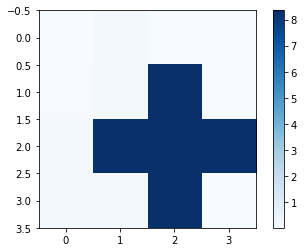

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[13.69193  +39.194794j  -8.99714  -22.914076j   2.786144  +7.8207474j
  -9.004102 -24.104261j ]
 [-8.667251 -23.66116j    3.1388998 +7.9321356j  3.0373478 +7.780572j
   3.079061  +7.502606j ]
 [ 3.0757356 +7.8714356j  3.0638778 +7.6876564j -8.820101 -23.471024j
   3.0396202 +8.028085j ]
 [-8.734483 -23.30339j    3.085619  +8.159872j   3.086476  +7.8875785j
   3.1142383 +7.7396445j]]


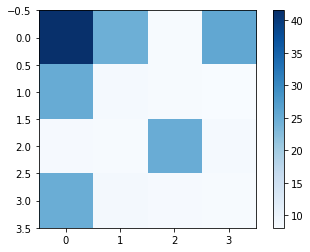

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: ' + str(test_imag))

Reals MSE: 2.230475e-15
Imaginaries MSE: 6.0320977e-15


## 3) Data encoding: basis embedding (non-conventional domain)

In [10]:
# vectorize input data
data = visibilities.flatten()

# get binary representations of real and imaginary parts
data_reals = []
data_imags = []
for i in range(0, len(data)):
    data_reals.append(float_to_bin_real(data[i].real))
    data_imags.append(float_to_bin_imag(data[i].imag))

# combine binary representations into a single array (reals then imaginaries)
data_binaries = data_reals + data_imags 

# sparse all binary representations strings into single characters
data_binary = []
for i in range(0, len(data_binaries)):
    data_binary.append([*data_binaries[i]])

# get rid of generated sub-arrays
inp = []
for i in range(0, len(data_binary)):
    inp += data_binary[i]

# make all character-strings integers
ini = []
for i in range(0, len(inp)):
    ini.append(int(inp[i]))

# n bits encoded onto n quibts
wires = range(len(ini)) 
bas_dev = qml.device('default.qubit', wires) # simulator (MOTIVATION?)

# encoding
@qml.qnode(bas_dev)
def basis_encoding(data):
    qml.BasisEmbedding(data, wires)
    return qml.state

readout = basis_encoding(ini)
print(readout)

ValueError: Maximum allowed dimension exceeded

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')